### **0. Quick introduction to jupyter notebooks**
* Each cell in this notebook contains either code or text.
* You can run a cell by pressing Ctrl-Enter, or run and advance to the next cell with Shift-Enter.
* Code cells will print their output, including images, below the cell. Running it again deletes the previous output, so be careful if you want to save some reuslts.
* You don't have to rerun all cells to test changes, just rerun the cell you have made changes to. Some exceptions might apply, for example if you overwrite variables from previous cells, but in general this will work.
* If all else fails, use the "Kernel" menu and select "Restart Kernel and Clear All Output". You can also use this menu to run all cells.

### **0.5 Some hardware setup**
Keras uses all available GPUs in your computer. The following ```os.environ``` commands configures that only one of them should be used. If you are on a system with several GPUs and want to use more than one, you can change or comment out these commands.

By default, Keras will allocate all of the available memory in the device. The last two lines will have Keras allocate memory as needed.

In [1]:
import os
import tensorflow as tf

# If there are multiple GPUs and we only want to use one/some, set the number in the visible device list.
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# This sets the GPU to allocate memory only as needed
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) != 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True) 

### **1. Introduction to Keras**
Keras is a Python API (Application Programming Interface) for fast development of neural networks that sits on top of TensorFlow, the machine learning platform developed by Google. The full documentation, which you probably will have to search at some point, can be found at https://www.tensorflow.org/api_docs/python/tf/keras.

To begin we should go through some of the essential terminology that you need to know for the rest of the assignment to go smoothly.

1. **Models**
    
    A Keras Model is, just like the name implies, the top-level object that describes your neural network architecture. This is the thing you create, train, and use to process data. It is very general and can be configured to perform essentially any task you want, such as image classification, text analysis, or continuous regression.
    

2. **Layers**
    
    These are the fundamental building blocks of the Model. Each Model contains a list of Layers. The way these are connected to each other defines the architecture of the network. There is a huge number of Layers, such as ```Dense```, which is the same fully connected layer you implemented in assignment 1. Another very important Layer is ```Conv2D```, which performs 2-dimensional convolution of the input using some filter.
    
    
3. **Optimizers, Losses, and Metrics**

    These are the functions and algorithms used to train and evaluate the Model.
    * The Optimizer defines the algorithm used to update the weights using the gradients. In the first assignment you implemented stocastic gradient descent (SGD), which is one type of Optimizer. 
    * Losses are differentiable objective functions that compute the performance quantity that the model tries to minimize. One example of a loss function is Mean Squared Error, which you used in the first assignment. Another is Categorical Crossentropy (*aka.* log-loss) which we will use this time.
    * Metrics are functions that compute the performance of the network in a way that is humanly understandable. Unlike the Losses, Metrics don't need to be differentiable since we don't use them in the gradient calculations. A perfect example of this is Accuracy; it's easily understood, but we can't use it as a Loss function.
    
We will look at all of this in more detail further down.

### **2. Loading the dataset**
For this introduction, we will use the MNIST dataset as for assignment 1. This time however, we will use the higher resolution images. We start by importing Keras and loading the dataset.

In [3]:
from tensorflow import keras

(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

print("Shape of training data:")
print(X_train.shape)
print(y_train.shape)
print("Shape of test data:")
print(X_test.shape)
print(y_test.shape)

11493376/11490434 [==============================] - 1s 0us/step
Shape of training data:
(60000, 28, 28)
(60000,)
Shape of test data:
(10000, 28, 28)
(10000,)


#### **Plotting images**
In order to create nice plots in Python we use a library called *matplotlib*. As the name suggests, this gives access to Matlab-like plot functions, although without the interactive elements. When we call ```plt.show()``` the current figure is rendered as a *.png* and displayed.

Here we select some random examples from the X_train matrix and show them as images (you might need to run the cell twice to see the images).

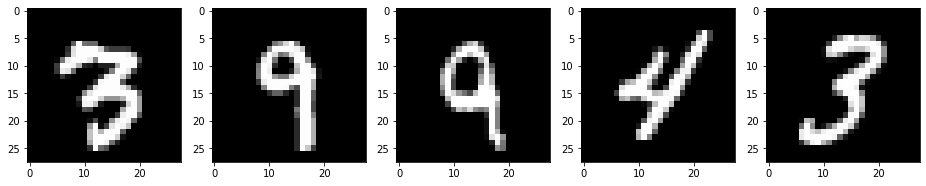

In [4]:
import matplotlib.pyplot as plt
import numpy as np

fig, axarr = plt.subplots(1, 5, figsize=(16,3))

for i in range(5):
    rnd = np.random.randint(low=0, high=X_train.shape[0])
    img = X_train[rnd]
    axarr[i].imshow(img, cmap=plt.get_cmap('gray'))
plt.show()

#### **Preparing the dataset**
We need to make some transformations to the data before we can use it for training. It's possible to use the data as is, but the results will not be very good. We will leave it as an exercice as to why that is the case.

The first step is to change the labels from a number representation, i.e. 1,2,3 etc., to a ***one-hot encoding*** where each target is a vector with only one of the values set to 1, the rest 0. This represents the probability that the output from the network should try to mimic. The concept is the same as the <strong>D</strong> matrix from the first assignment. A minor difference is that in **D**, each target was a vector with a single 1 and the rest -1. This is because we used *tanh* as output activation, which outputs in the [-1, 1] range. In this assignment we use *softmax* activation in the output layer, which only give values beween 0 and 1, thus the one-hot encoding.

<small>*As a side note for those of you that are interested. While the change from a -1/1 vector to a 0/1 (one-hot) vector might not seem that significant at first, the gradient calculation is very nice when using both softmax activation and cross-entropy loss in the output layer, as several terms cancel. We will let Keras do all the work for us this time, but if you ever need to implement a general backpropagation algorithm from scratch, or you just really like partial derivatives :), this is something to look into.*</small>

Second, we intensity normalize the data to the [0,1] range, instead of [0,255]. This is not strictly necessary as all weights will just scale to account for the change, but the convergence is much faster. The reason for this is that Keras uses specific initialization schemes for the weights that expect the data to be [0,1] normalized.

In [5]:
# Transform label indices to one-hot encoded vectors
y_train_c = keras.utils.to_categorical(y_train, num_classes=10)
y_test_c  = keras.utils.to_categorical(y_test, num_classes=10)

# Normalization of pixel values (to [0-1] range)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

# Print some labels
print("Label index --> one-hot encoding")
for i in range(5):
    print(str(y_train[i]) + " --> " + str(y_train_c[i]))

Label index --> one-hot encoding
5 --> [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
0 --> [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
4 --> [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
1 --> [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
9 --> [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


### **3. A first Keras model**
Now let's build our first Model for classifying the MNIST data. In Keras, there are two different ways to create a model. The first is using the **Sequential** API which can only build networks that have a single stack of layers. We can add new layers to the network by calling ```model.add(...)```. This is nice and simple but is limited to a single stack of layers.

*Why would you need anything else, you might ask. Nowadays most models for deep learning connect layers not just sequentially, but also using longer connection that "skip" one or more layers before merging into the network again. These, called skip connections or residual connections, are very powerful but also outside the scope of this course. For a concrete example lookup the popular ResNet architecture.*

The second way to build models is using the **Functional** API. In this, we treat each layer as an individual function and we manually use the output from one (or more) layer as the input to another layer. This gives much more flexibility in designing the network architecture. For this reason, we will use the Functional API even though the Sequential would do just fine for this assignment. This will give you more freedom in the final task and better prepare you for any future projects you want to do.

We will begin by building a model very similar to the one from assignment 1, *i.e.* a two-layer fully connected (Dense) network.

In [6]:
# Import some stuff we need
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten

# Create the input layer
x_in = Input(shape=X_train.shape[1:])

# Create the rest of the layers
x = Flatten()(x_in)
x = Dense(64, activation='tanh')(x)
x = Dense(10, activation='softmax')(x)

# Create the model object
model = Model(inputs=x_in, outputs=x)

We want you to really understand what is going on here, so let's go through this step by step. 
1. ```x_in = Input(shape=X_train.shape[1:])```: this creates the input layer using the ```Input``` class. This requires the shape of the input data, which is given by ```X_train.shape[1:]```. We use ```[1:]``` to select only the height and width of the images, skipping the number of images. If this is unfamiliar to you, we recommend section 3.1.3 in the official python tutorial: https://docs.python.org/3/tutorial/introduction.html. The output from the input layer, which we call ```x_in```, is a data structure that can be used as input to other layers.

 *As a side note, normally when we think of the output of a function we expect that to be some data that we can plot or visualize in some way, like the value 5, or a vector, etc. However, remember that we have not given any data to this model yet, so there is no data to visualize. Here instead we are defining how to process the input data that will eventually be given to the model. When feeding the input of a layer to another, we add a new operation to our process. Remember, a neural network is just a function. It can be a very complicated function, but a function nonetheless, and is therefore just a series of operations.* 
 

2. ```x = Flatten()(x_in)```: simply changes the shape of the input data. The MNIST dataset is images of size 28x28 pixels. However, the next ```Dense``` layer expects all features in a single dimension. The flatten operation simply squashes multidimentional arrays into a single vector (in our case from 28x28 to 784). Note that when we add the ```Flatten``` layer we directly give it the input in the same line of code, *i.e.* ```x = Flatten()(x_in)```. This is a nice trick because it means we don't have to save the layer itself to a variable before using it; we can just define and use it on the same line which saves both space and time. You can test this by running the following cell, which creates a standalone ```Flatten``` layer and processes the first 5 images in X_train. 

In [7]:
# TEST for the Flatten() layer
F = Flatten(input_shape=(28,28))

''' don't worry about the following operation. This it to make sure that the data 
is in the right format to be processed by Keras. This is automatically taken care 
of when using the input layer.'''
In = tf.convert_to_tensor(X_train[0:5])
Out = F(In)

print("Before Flatten: " + str(In.shape))
print("After Flatten : " + str(Out.shape))

Before Flatten: (5, 28, 28)
After Flatten : (5, 784)


3. ```x = Dense(64, activation='tanh')(x)``` and ```x = Dense(10, activation='softmax')(x)```: defines two dense layers, the first with 64 nodes and the second with 10, as the number of output classes. For the hidden layer we specify *tanh* as activation function , whereas *softmax* for the output layer.

    Specifying the activation directly when creating the layer is not the only way to do it; there is a layer called ```Activation``` that can be used to add a standalone activation function between layers. This is sometimes necessary, for example when using more advanced activation functions, such as LeakyReLU. We also sometimes want to add normalization layers within the network to improve the training, which we will see in the main assignment. In these cases we usually apply the activation function after normalization, which requires using a separate ```Activation``` layer.


4. ```model = Model(inputs=x_in, outputs=x)```: creates the actual model object. We initialize it with the input and output of the network, which we have in ```x_in``` and ```x```. At the moment we don't need any outputs from the middle layers, which is why we overwrite ```x``` when adding new layers. However, we must always save a separate variable for the input layer to create the model.


Notice how we only specify the shape of the data at the first layer, using ```X_train.shape[1:]```. Although every layer has this input parameter, we only need to specify the input shape of the first layer since the model takes care of the rest for us.  No more struggling with matrix sizes. Neat!

#### **Finalizing the model**
Now that we defined the architecture of our model, we need to specify the way we want to train and evaluate it, *i.e.* the Optimizer, Loss function and any Metrics. As Optimizer we will use Mini-batch Stocastic Gradient Descent, which is implemented in the ```SGD``` class. This is almost the same as in assignment 1, except that we don't process the entire dataset before taking a learning step. Instead we randomly divide the data in mini-batches of a few examples, typically a relatively small power of 2, and take a step for each of them. This makes learning faster since we take more steps per epoch than if we were to use the entire dataset for each step. It's also sometimes necessary since the dataset can be so large that it doesn't fit in memory. In other words, batch SGD takes one step based on the mean of the gradient from all data, whereas mini-batch SGD takes multiple steps where each is the mean computed over a fixed number of samples (batch size).

We will also use Nesterov momentum and learing rate decay in the optimizer. Don't worry if this doesn't mean anything to you, it's just a specific improvement to the base SGD algorithm that tries to be smart about the learning step. You will see that it is very good for this problem.

We will use *categorical crossentropy* as loss function, which uses the *log* of predicted probabilites to calculate the loss, which exponentially punishes predictions the more wrong they are. For the metric we will use accuracy, *i.e.* the fraction of the data classified correctly. Note that we can give several metrics to the model if we want, but in this case we will only use accuracy.

We set the optimizer, loss function, and metrics using the ```model.compile``` method.

In [8]:
from tensorflow.keras.optimizers import SGD

# Define the optimizer
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

# Compile the model using the optimizer, loss and metric
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

#### **Inspecting the model**
Now that we have a model, we can do some visualization. First, let's print a table summarizing the model with ```model.summary``` (the parameter is simply the width of the table).

In [9]:
model.summary(60)

Model: "model"
____________________________________________________________
Layer (type)               Output Shape            Param #  
input_1 (InputLayer)       [(None, 28, 28)]        0        
____________________________________________________________
flatten (Flatten)          (None, 784)             0        
____________________________________________________________
dense (Dense)              (None, 64)              50240    
____________________________________________________________
dense_1 (Dense)            (None, 10)              650      
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
____________________________________________________________


We can see the type, output size, and number of parameters for each layer. This is very useful when working with larger models. For example we might want to find out why the model is overfitting. Is there a layer with a lot of parameters? That might be a good candidate to change. Having many parameters to train is also slower, so changing the network by adding or removing layers might speed up training. Finally there's a summary at the bottom with the total number of parameters. Some layers have parameters that are configurable but not part of the optimization, these are the *Non-trainable params* of which we currently have none.

Note how the first value of the output shape is **None**. This just means that we haven't specified the mini-batch size yet. We do this when we actually train the model.

We can also print an image of the model using the code below. This might seem unnecessary when we have the table, and at the moment it gives roughly the same information. However, when building more advanced models, for example using residual connections, the table quickly becomes unreadable.

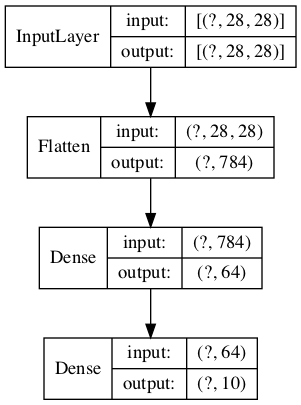

In [10]:
keras.utils.plot_model(model, show_shapes=True, show_layer_names=False)

#### **Training the model**
Finally, time to do some model training! This is done with the ```model.fit``` method. We input the training data, one-hot encoded targets, mini-batch size, and number of epochs. When using mini-batches, one epoch passes when all the data has been used once. Each training sample can only be used once per epoch, thus the mini-batches are randomly selected each epoch, which is why it's called stochastic gradient decent.

We also set the *validataion_split* parameter to 0.2. This tells ```model.fit``` to split off 20% of the training data to use for validation during the training process. In the previous assignment we used the test data for this purpose, but this is not how it's usually done. We might want to use the validation data during training to make decisions, such as stopping early if we detect overfitting or decreasing the learning rate if we detect that the performance no longer improves. But that means we cannot use the same data to get the final performance of the model, as it has influenced the training and the model parameters. This is why we need three datasets, one for training, one for validation during training, and one for testing after training. Using the *validation_split* parameter we get a random selection from the training data for validation, but we can also give a specific validation set to the ```fit``` method if we want, or we can tell it to always use the first 20%, etc. 

Finally, setting the *verbose* flag to 1 prints the status of the training. Now let's run it!

In [11]:
history = model.fit(X_train, y_train_c, epochs=10, batch_size=32, verbose=1, validation_split=0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 11s 224us/sample - loss: 0.3603 - accuracy: 0.8966 - val_loss: 0.2227 - val_accuracy: 0.9359
Epoch 2/10
48000/48000 [==============================] - 9s 196us/sample - loss: 0.2015 - accuracy: 0.9414 - val_loss: 0.1705 - val_accuracy: 0.9528
Epoch 3/10
48000/48000 [==============================] - 13s 271us/sample - loss: 0.1530 - accuracy: 0.9559 - val_loss: 0.1482 - val_accuracy: 0.9588
Epoch 4/10
48000/48000 [==============================] - 13s 276us/sample - loss: 0.1255 - accuracy: 0.9640 - val_loss: 0.1378 - val_accuracy: 0.9608
Epoch 5/10
48000/48000 [==============================] - 13s 277us/sample - loss: 0.1063 - accuracy: 0.9695 - val_loss: 0.1258 - val_accuracy: 0.9632
Epoch 6/10
48000/48000 [==============================] - 11s 238us/sample - loss: 0.0918 - accuracy: 0.9747 - val_loss: 0.1210 - val_accuracy: 0.9641
Epoch 7/10
48000/48000 [=====================

#### **Evaluating the model**
We evaluate the model on the test data using the ```model.evaluate``` method, which returns the loss and metrics. The results can vary, but should generally be around 97% accuracy. Remember that the first assignment required only 93%. Not bad for a few lines of code and 10 epochs, right?

In [ ]:
score = model.evaluate(X_test, y_test_c, verbose=0)

for i in range(len(score)):
    print("Test " + model.metrics_names[i] + " = %.3f" % score[i])

We can also plot the history of the training using the *history* object that is returned from ```model.fit```. This again uses the *matplotlib* library.

In [ ]:
plt.figure(figsize=(12,5))

# Plot loss
plt.subplot(1,2,1)
plt.semilogy(history.history['loss']    , label="Training")
plt.semilogy(history.history['val_loss'], label="Validation")
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True, which="both")

# Plot accuracy
plt.subplot(1,2,2)
plt.plot(100 * np.array(history.history['accuracy'])    , label="Training")
plt.plot(100 * np.array(history.history['val_accuracy']), label="Validation")
plt.title('Model accuracy')
plt.ylabel('Acc [%]')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.grid(True, which="both")

plt.show()

We can also import some libraries to calculate and view the confusion matrix. For this we want to get the predicted class for each test sample, which we can do with ```model.predict```. However, since the model outputs a 10-class probabilty vector we need to convert it back to a label index vector (*i.e.* 1,2,3 etc.). Use ```np.argmax``` for this.

In [ ]:
from sklearn.metrics import confusion_matrix
from Custom import PrintPrediction

# Probabilities for each class, for each test image
prob_test = model.predict(X_test)
# Prediction (class number) for each test image.
p_test = np.argmax(prob_test,axis=1)
# Calculate confusion matrix
CM = confusion_matrix(y_test, p_test)

# Print probablities and predictions (rounded to a few decimal places)
print("Probabilites and predictions")
for i in range(5):
    PrintPrediction(prob_test[i])
    
print("\nConfusion matrix")
print(CM)

Here is a nice custom function for evaluating the model and plotting the history and confusion matrix. We will use this in the main part of the assignment, so you can focus on the fun parts instead of writing the plot code.

*The code for the Labels input is a bit of python magic called list comprehention. It's very nice and also very easy to make completly unreadable. Use responsibly :)*

In [ ]:
from Custom import PlotModelEval
plt.text
PlotModelEval(model, history, X_test, y_test, Labels=[str(x) for x in range(10)])

### **------------------------------------------------------------------------------------**
### **Extra, examples of more complicated models**
As a bonus, here are some short examples of models built using the functional API, that can't be created with the Sequential model.

##### **Adding a residual (skip) connection**
Residual (skip) connection are used in some of the most powerful modern architectures, for reasons that are outside the scope of this course. However, for a concreate example, lookup ResNet.

In [ ]:
# Import Keras and create some shorthand notation
import tensorflow.keras as keras
import tensorflow.keras.layers as L

# Begin like last time
x_in = L.Input(shape=100)
x = L.Dense(50, activation="tanh")(x_in)

# But now, save the output to another variable, y
y = L.Dense(10, activation="tanh")(x)

# Use y as new input, but then change back to x
x = L.Dense(10, activation="tanh")(y)
x = L.Dense(10, activation="tanh")(x)

# Now we have two different outputs from the network, at two different points.
# We can merge them using different Layers, for example Add, using a list of layer outputs:
x = L.Add()([x,y])

# Finally, add the output layer and create the model
x = L.Dense(5, activation="softmax")(x)
model2 = keras.models.Model(inputs=x_in, outputs=x)

# Print the model
model2.summary(100)

You can see on the right that there is a new column the shows the connections between layers. That's not very visual though, so let's print it as an image instead.

In [ ]:
keras.utils.plot_model(model2, show_shapes=True, show_layer_names=False)

##### **More than one input and output**
This can be useful when doing object recognition in images. You can imagine that you not only want to classify an image as a cat or dog, but also give the coordinates of the cat or dog in the image. Or even have a segmented images as output where the background is removed.

In [ ]:
# Import Keras and create some shorthand notation
import tensorflow.keras as keras
import tensorflow.keras.layers as L

x_in1 = L.Input(shape=100)
x_in2 = L.Input(shape=50)

x1 = L.Dense(20, activation="tanh")(x_in1)
x2 = L.Dense(10, activation="tanh")(x_in2)
c1 = L.Concatenate()([x1,x2])
x3 = L.Dense(10, activation="tanh")(c1)
x4 = L.Dense(10, activation="tanh")(c1)

model3 = keras.models.Model(inputs=[x_in1, x_in2], outputs=[x3,x4])

# Print the model
keras.utils.plot_model(model3, show_shapes=True, show_layer_names=False)

##### **A (not so) crazy model**

You can also very easily make some crazy models. Here is a network where the input to each layer is the sum of outputs from all previous layers. While this particular model is just a dummy, similar techniques where there is a high degree of connectivity between the layers have actually been used in some scientific publications, for example to detect diseases in X-Ray images.

In [ ]:
# Import Keras and create some shorthand notation
import tensorflow.keras as keras
import tensorflow.keras.layers as L

# Begin like last time
x_in = L.Input(shape=100)

x1 = L.Dense(10, activation="tanh")(x_in)
x2 = L.Dense(10, activation="tanh")(x1)
a1 = L.Add()([x1,x2])
x3 = L.Dense(10, activation="tanh")(a1)
a2 = L.Add()([x1,x2,x3])
x4 = L.Dense(10, activation="tanh")(a2)
a2 = L.Add()([x1,x2,x3,x4])

x = L.Dense(5, activation="tanh")(a2)
model4 = keras.models.Model(inputs=x_in, outputs=x)

# Print the model
keras.utils.plot_model(model4, show_shapes=True, show_layer_names=False)